In [1]:
import torch
import torch.nn as nn

import emg2qwerty.data as data

import numpy as np
from wavelets_pytorch.transform import WaveletTransform        # SciPy version
from wavelets_pytorch.transform import WaveletTransformTorch   # PyTorch version

In [2]:
d = data.WindowedEMGDataset("/home/lawrence/emg2qwerty/data/2020-08-15-1597560433-keystrokes-71409769.hdf5",
                            window_length = 8000,
                            padding= [1800,200])

In [3]:
for i in range(len(d)):
    emg,strokes = d[i]
    if len(strokes) > 0:
        print(i)
        print(emg.shape)
        print(strokes.shape)
        break

5
torch.Size([10000, 2, 16])
torch.Size([7])


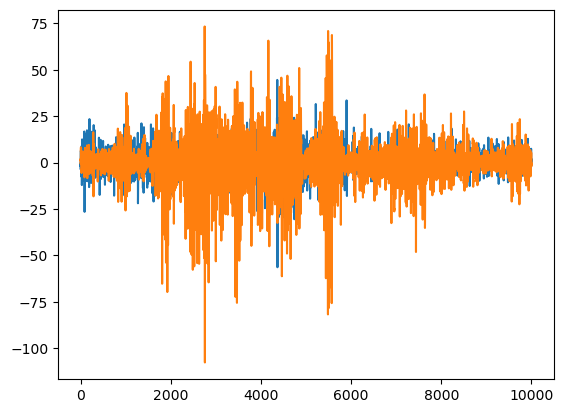

In [4]:
import matplotlib.pyplot as plt


plt.plot(emg[:,0,0])

plt.plot(emg[:,1,0])

In [5]:
#construct FFTs

import torch.fft as fft

window_lengths = 500
#for each window, compute the FFT of each channel

data = emg.transpose(0,2)
print(data.shape)
data_reshaped = data.reshape(-1, window_lengths)
print(data_reshaped.shape)
ffts = fft.rfft(data_reshaped, dim=1)

ffts = torch.log(ffts.abs() + 1e-6)
print(ffts.shape)

torch.Size([16, 2, 10000])
torch.Size([640, 500])
torch.Size([640, 251])


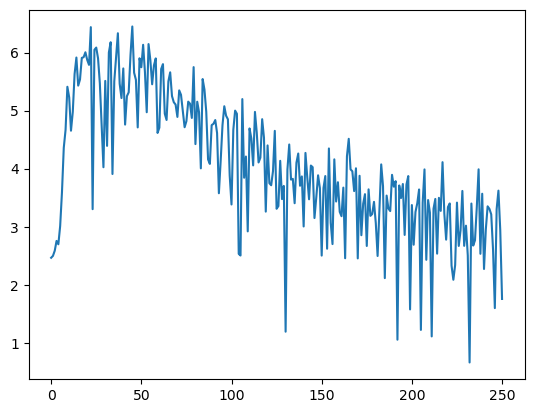

In [6]:
plt.plot(ffts[10,:])

torch.Size([16, 2, 20, 251])


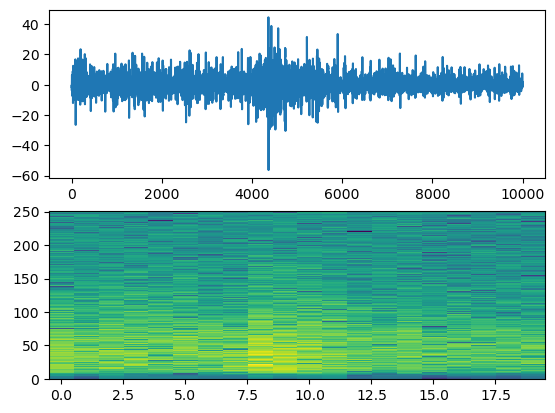

In [7]:
ffts = ffts.reshape(data.shape[0], data.shape[1], -1, ffts.shape[-1])
print(ffts.shape)

i,j = 0,0

fig,axs = plt.subplots(2,1)
# plt.plot(data[i,j,:])
axs[0].plot(data[i,j,:])
axs[1].imshow(ffts[i,j,:,:].detach().numpy().T, aspect='auto', interpolation='nearest',origin='lower')
# plt.imshow(ffts[i,j,:,:].detach().numpy(), aspect='auto')

In [8]:
f_sample = float(d.session.metadata["daq_sample_rate"])



dt = 1/f_sample         # sampling frequency
dj = 0.0125              # "wavelet width" (default value)

data = emg.transpose(0,2)
print(data.shape)
data = data.reshape(-1, data.shape[-1])
print(data.shape)

wa_torch = WaveletTransformTorch(dt, dj, cuda=True)


cwt_torch = wa_torch.cwt(data.numpy())

torch.Size([16, 2, 10000])
torch.Size([32, 10000])


In [9]:
cwt_torch.shape

(32, 987, 10000)

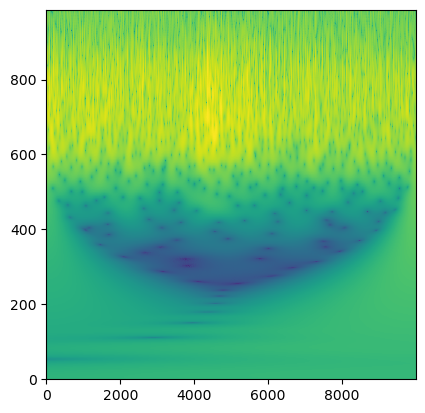

In [10]:
# fig,axs = plt.subplots(2,1)
# plt.sca(axs[0])
# plt.plot(data[0,:])
# plt.sca(axs[1])
plt.imshow(np.log(np.abs(cwt_torch[0][::-1])), aspect=len(data[0])/len(cwt_torch[0]), interpolation='nearest',origin='lower')

In [11]:
import torch
from pytorch_wavelets import DWT1DForward, DWT1DInverse

dwt = DWT1DForward(wave='db6', J=500).cuda()

data = torch.tensor(data, dtype=torch.float32).cuda()

cA, cD = dwt(data.unsqueeze(0))

cA.shape

for 

SyntaxError: invalid syntax (2395442361.py, line 12)

In [24]:
#get the spectrogram
from torchaudio.transforms import Spectrogram

spec = Spectrogram(
            n_fft=256,
            hop_length = 64,
            # normalized=True,
            # Disable centering of FFT windows to avoid padding inconsistencies
            # between train and test (due to differing window lengths), as well
            # as to be more faithful to real-time/streaming execution.
            # center=False,
        )

spec_torch = spec(torch.tensor(data))

spec_torch.shape


/tmp/ipykernel_3593/3412408975.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spec_torch = spec(torch.tensor(data))


torch.Size([32, 129, 157])

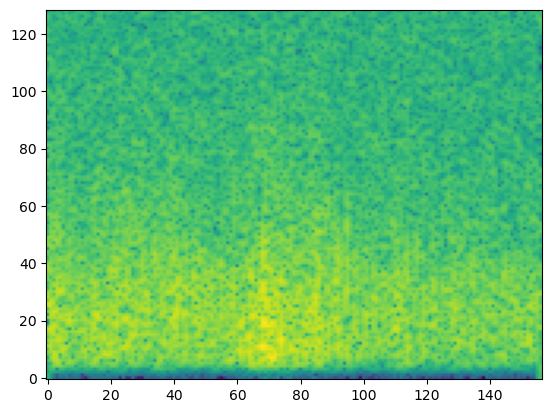

In [25]:
plt.imshow(np.log(spec_torch[0].numpy()), aspect='auto', origin="lower")

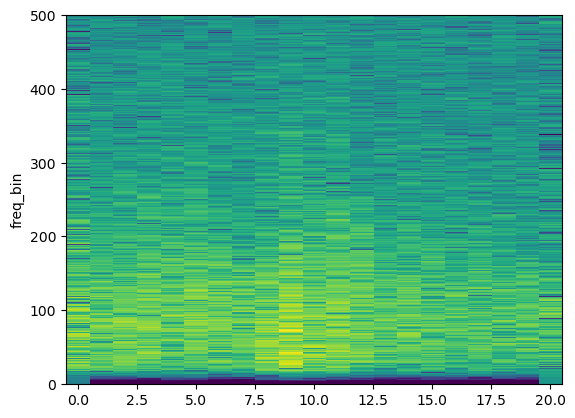

In [120]:
import librosa

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


plot_spectrogram(spec_torch[0].numpy())